In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import shutil             # to copy images to another directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.style.use('ggplot')

In [7]:
base_dir = "C:\\Users\\User\\senzo download\\Groundnut_Leaf_dataset\\Groundnut_Leaf_dataset"

for directory in os.listdir(base_dir):
    print(f'The parent directory is {base_dir}/{directory}')

The parent directory is C:\Users\User\senzo download\Groundnut_Leaf_dataset\Groundnut_Leaf_dataset/test
The parent directory is C:\Users\User\senzo download\Groundnut_Leaf_dataset\Groundnut_Leaf_dataset/train


In [8]:
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'test')

In [9]:
# our dataset contains 38 different categories that need to be classified
def print_categories(folder_dir):
    categories = []
    for direc in os.listdir(folder_dir):
        categories.append(direc)
        print(direc)
    return categories

In [10]:
print_categories(train_dir)

early_leaf_spot_1
early_rust_1
healthy_leaf_1
late_leaf_spot_1
nutrition_deficiency_1
rust_1


['early_leaf_spot_1',
 'early_rust_1',
 'healthy_leaf_1',
 'late_leaf_spot_1',
 'nutrition_deficiency_1',
 'rust_1']

In [11]:
cat = ['early_rust_1','late_leaf_spot_1','nutrition_deficiency_1','healthy_leaf_1','early_leaf_spot_1','rust_1']

In [12]:
def categories_percentage(folder_dir):
    cat_percent_dict = {}
    for direc in os.listdir(folder_dir):
            cat_percent_dict[f'{direc}'] = len(os.listdir(os.path.join(f'{folder_dir}',f'{direc}')))
    return cat_percent_dict

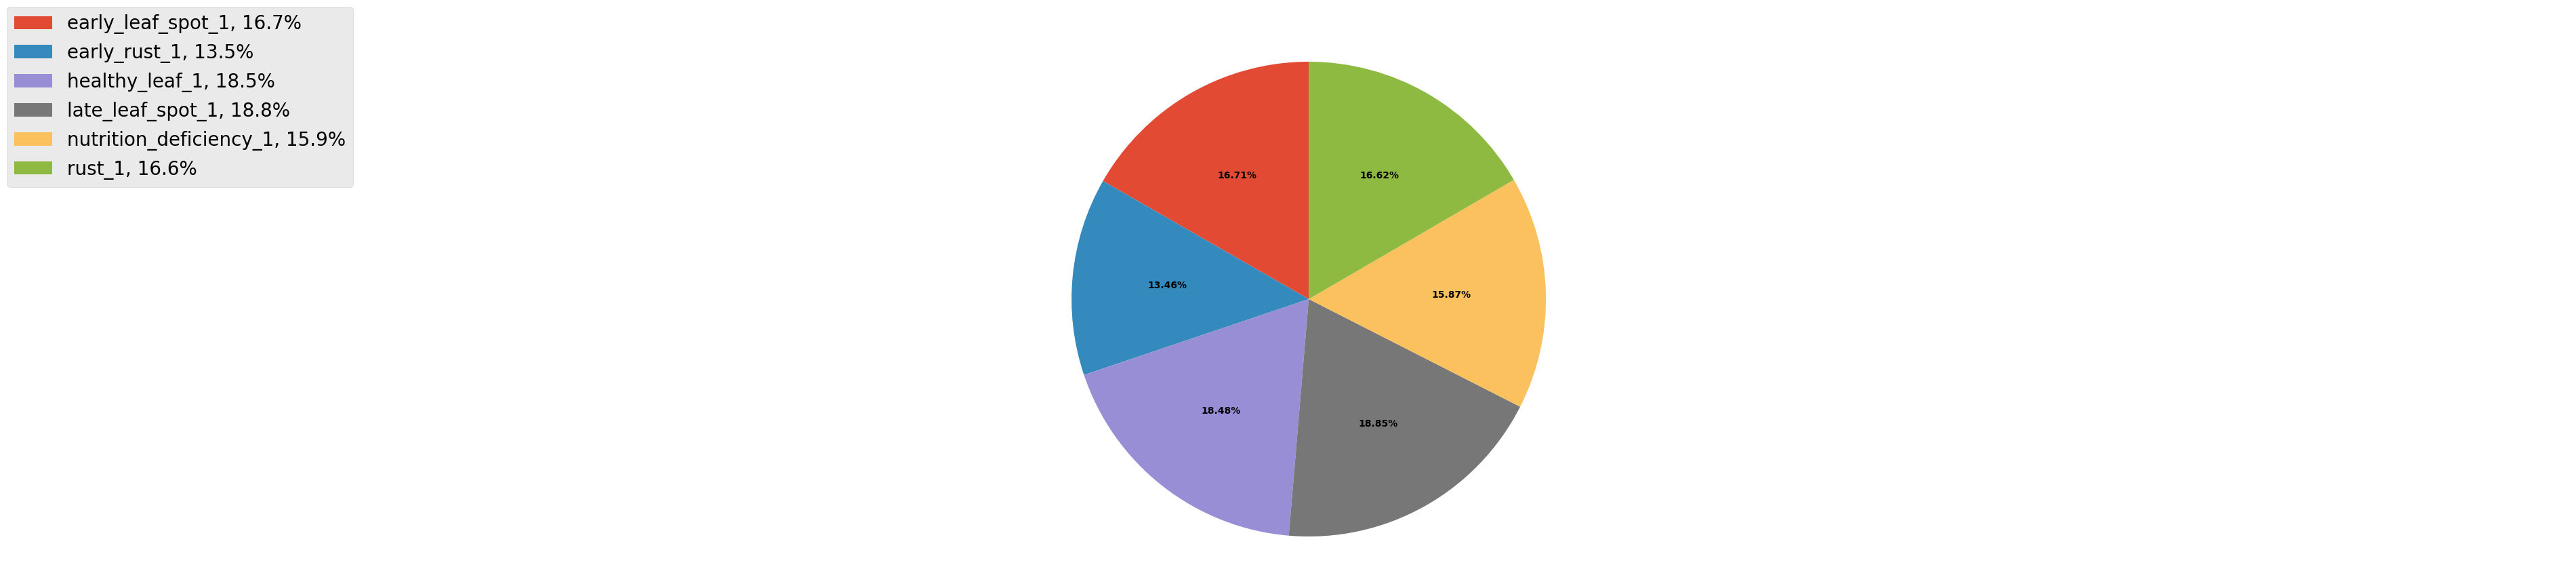

In [13]:
train_cat_num = categories_percentage(train_dir)
def autopct_generator(limit):
    """Remove percent on small slices."""
    def inner_autopct(pct):
        return ('%.2f%%' % pct) if pct > limit else ''
    return inner_autopct

#define Seaborn color palette to use
#palette_color = seaborn.color_palette('bright')
fig1, ax1 = plt.subplots(figsize=(6, 5))
box = box = ax1.get_position()
ax1.set_position([box.x0, box.y0-box.height, box.width * 8, box.height*2])
# plotting data on chart
_, _, autotexts = ax1.pie(
    train_cat_num.values(), autopct=autopct_generator(7), startangle=90, radius=4000)
for autotext in autotexts:
    autotext.set_weight('bold')
ax1.axis('equal')
total = sum(train_cat_num.values())

plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(train_cat_num.keys(), train_cat_num.values())],
    prop={'size': 20},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

In [14]:
CLASS_NAMES = cat.copy()
#initialising necessary properties
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(10000/BATCH_SIZE)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
# test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
# training data generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=BATCH_SIZE,
        shuffle=True,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = list(CLASS_NAMES),
       # subset='training'
)
# validation data generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = list(CLASS_NAMES),
        batch_size=BATCH_SIZE,
        #subset='training'
)

Found 7910 images belonging to 6 classes.
Found 2451 images belonging to 6 classes.


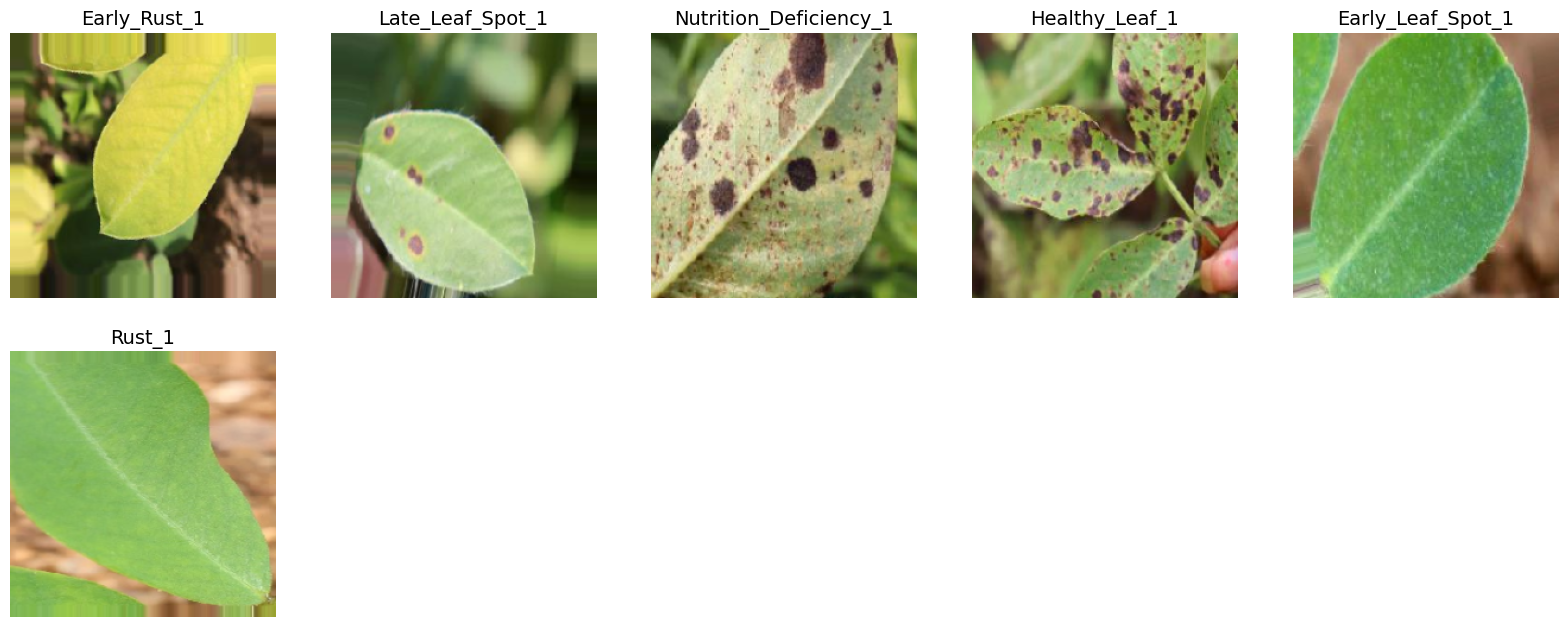

In [16]:
def show_batch(image_batch, label_batch):
      fig = plt.figure(figsize=(20,20))
      fig.patch.set_facecolor('white')
      for n in range(6):
          ax = plt.subplot(5,5,n+1)
          plt.imshow(image_batch[n])
          plt.title(CLASS_NAMES[n].title(), fontsize=14)
          plt.axis('off')
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)
num_classes = 6  # Change this to the actual number of classes in your dataset

# Create a sequential model
model = tf.keras.Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output for fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
epochs = 16

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

#  Save best model every epoch
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_weights.weights.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
#fit the model
history = model.fit(train_generator, 
                    epochs=epochs,
                    validation_data = validation_generator,
                    callbacks=[early_stopper, reduce_lr,model_checkpoint])

Epoch 1/16


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3891 - loss: 1.6442
Epoch 1: val_accuracy improved from -inf to 0.73888, saving model to best_weights.weights.h5
248/248 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.3895 - loss: 1.6427 - val_accuracy: 0.7389 - val_loss: 0.6428 - learning_rate: 0.0010
Epoch 2/16
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6095 - loss: 0.9614
Epoch 2: val_accuracy improved from 0.73888 to 0.83272, saving model to best_weights.weights.h5
248/248 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.6095 - loss: 0.9614 - val_accuracy: 0.8327 - val_loss: 0.5863 - learning_rate: 0.0010
Epoch 3/16
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6489 - loss: 0.8580
Epoch 3: val_accuracy improved from 0.83272 to 0.83803, saving model to best_weights.weights.h5
248/248 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.6490 - loss: 0.8579 - val_accuracy: 0.8380 - val_loss: 0.4819 - learning_rate: 0.0010
Epoch 4/16
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2s

In [23]:
from tensorflow.keras.utils import plot_model
# Assuming 'model' is your trained Keras model
plot_model(model, to_file='model_architecture.png', show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


77/77 ━━━━━━━━━━━━━━━━━━━━ 25s 317ms/step


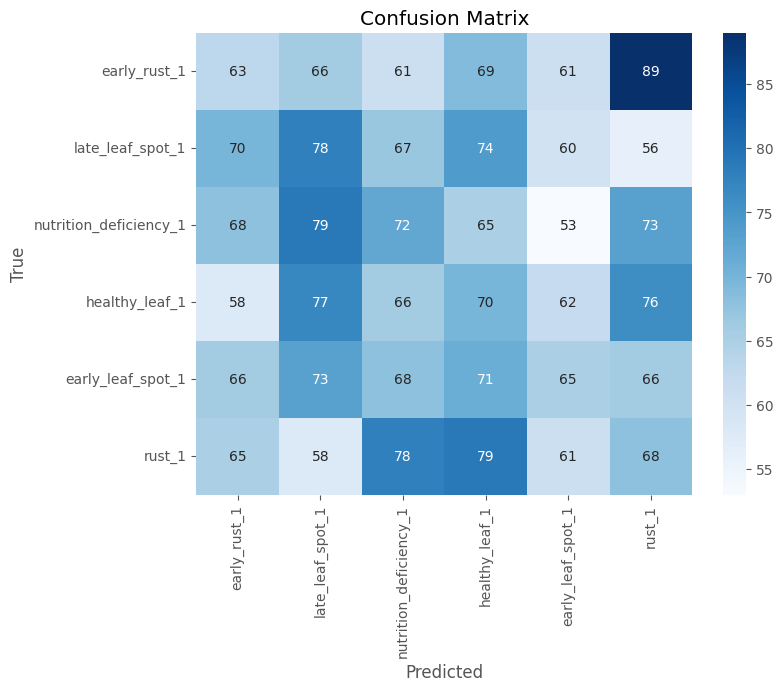

In [24]:
# Assuming 'model' is your trained Keras model
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)
# Assuming 'validation_generator' yields batches of data in the same order as the ground truth labels
true_labels = validation_generator.classes
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

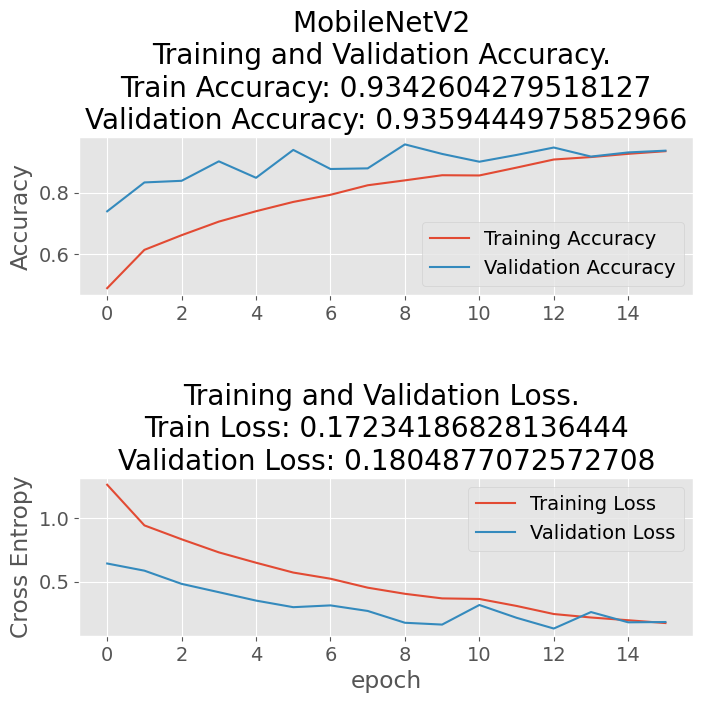

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [26]:
file_h5 = "Groundnut_disease_model.h5"
tf.keras.models.save_model(model, file_h5)

In [27]:
# quantization,converts the model to a smaller format by reducing the size by about 75%
def from_keras_model(kmodel):
        converter = tf.lite.TFLiteConverter.from_keras_model(kmodel)
        tflite_model = converter.convert()
        return tflite_model
def write_model(tflite_model,path):
    tflite_model_files = pathlib.Path(path)
    tflite_model_files.write_bytes(tflite_model)

In [1]:
import pathlib
tflite_model = from_keras_model(model)
write_model(tflite_model,'edge_model.tflite')

NameError: name 'from_keras_model' is not defined